In [200]:
import pandas as pd
import os
import re
import itertools
import collections
from wordcloud import WordCloud

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

import random
from numpy.random import seed

from topic_SCORE import *

In [2]:
# Read data into papers
papers = pd.read_csv('./data/NIPS_Papers/papers.csv')

# Print head
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


# EDA

(array([7.700e+01, 2.388e+03, 3.689e+03, 3.970e+02, 6.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([9.000000e+00, 1.238080e+04, 2.475260e+04, 3.712440e+04,
        4.949620e+04, 6.186800e+04, 7.423980e+04, 8.661160e+04,
        9.898340e+04, 1.113552e+05, 1.237270e+05]),
 <a list of 10 Patch objects>)

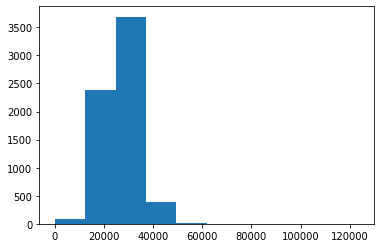

In [13]:
text_len = np.zeros(len(papers))
for i in range(len(papers)):
    text_len[i] = len(papers['paper_text'].values[i])

plt.hist(text_len)

In [4]:
print(len(papers))
print(sum(papers['abstract'].values == "Abstract Missing"))

6560


3317

In [6]:
collections.Counter(papers['event_type'].values)

Counter({nan: 4819, 'Oral': 55, 'Spotlight': 181, 'Poster': 1505})

In [37]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# create list of words to remove
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liwan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# create 2 lists of words to remove: stop words and noninformative words
stop_words = stopwords.words('english')

noninfo_words = ['from', 're', 'edu', 'com', 'cn', 'use','used','using', 'etc', 'et', 'al','one','two','three','four','five',
                'six','seven','eight','nine','ten','case','corresponding','well','set','see','saw','have','get','define',
                'definition','thu','give','gives','given','giving']
single = []
for i in range(ord('z') - ord('0')):
    single.append(chr(ord('0') + i))
noninfo_words.extend(single)

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_words(texts, word_list):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in word_list] for doc in texts]

def preprocess(text, stop_words, noninfo_words):
    '''
    input: n x . vector of strings
    output: n x . vector of list of words 
    '''
    text_processed = [re.sub('[,\.!?]', '', x) for x in text]
    text_processed = [x.lower() for x in text_processed]
#     text_processed = text_processed.tolist()
    text_processed = sent_to_words(text_processed)
    text_processed = remove_words(text_processed, stop_words)
    text_processed = remove_words(text_processed, noninfo_words)
    return text_processed

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liwan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['bayesian', 'query', 'construction', 'neural', 'network', 'models']


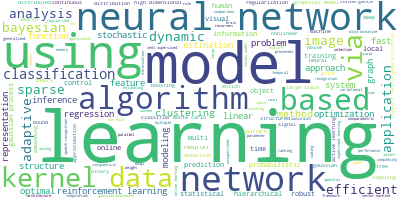

In [185]:
paper_title = preprocess(papers['title'].values.tolist(), stop_words, noninfo_words)
print(paper_title[3])

long_string = ','.join(list(itertools.chain.from_iterable(paper_title)))
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [61]:
start_time = time.time()

paper_text = preprocess(papers['paper_text'].values.tolist(), stop_words, noninfo_words)

print("--- %s seconds ---" % (time.time() - start_time))

--- 254.7820508480072 seconds ---


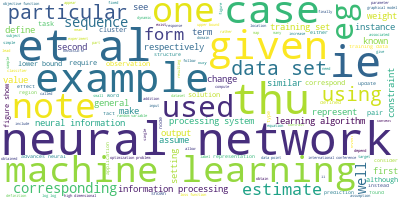

In [62]:
long_string = ','.join(list(itertools.chain.from_iterable(paper_text)))
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

# Topic modelling

In [82]:
import gensim.corpora as corpora

# create dictionary: id2word[i] is the word with index i
id2word = corpora.Dictionary(paper_title)

# create corpus: corpus[i] is a list of the word frequency for document i
texts = paper_title
corpus = [id2word.doc2bow(text) for text in texts]

# create word-document frequency matrix
n_doc, n_word = len(corpus), max(id2word.keys()) + 1
word_doc = np.zeros((n_doc, n_word))

for i in range(n_doc):
    for x in corpus[i]:
        word_doc[i][x[0]] = x[1]

In [77]:
id2word[0]

'applications'

In [159]:
start_time = time.time()

# tscore_result = topic_score(word_doc = word_doc, K_topic = 10, K_cand = 15, n_cluster = 20)
tscore_result = topic_score(word_doc = word_doc, K_topic = 5, K_cand = 10, n_cluster = 15)

print("--- %s seconds ---" % (time.time() - start_time))

--- 12.244667530059814 seconds ---


In [160]:
A_hat, R, V, Pi, theta = tscore_result

In [161]:
lam = 0.05
W_hat = np.linalg.solve(A_hat.T @ A_hat + lam * np.eye(A_hat.shape[1]), A_hat.T @ word_doc).T
print(W_hat.shape[0] * W_hat.shape[1])
print(np.sum(W_hat < 0))

W_hat[W_hat < 0] = 0
rowsum = W_hat.sum(axis = 1)
W_hat_row = (W_hat.T / rowsum).T

25660
8458


In [165]:
top = 20
K_topic = W_hat.shape[1]
anchor_word = pd.DataFrame({i:[''] * top for i in range(K_topic)})
for i in range(K_topic):
    ix = np.argsort(-W_hat_row[:,i])[:top]
    for j in range(top):
        anchor_word.iloc[j, i] = id2word[ix[j]] + ' | ' + str(round(W_hat_row[ix[j],i], 2))
anchor_word

,0,1,2,3,4
0,stimulated | 1.0,psdboost | 1.0,breast | 0.99,loose | 1.0,traverse | 0.99
1,periodically | 1.0,playlists | 0.98,benchmarking | 0.97,repulsive | 1.0,collections | 0.96
2,isih | 1.0,automatically | 0.98,survival | 0.88,var | 1.0,gigantic | 0.96
3,nongaussian | 1.0,chosen | 0.94,adds | 0.86,committing | 1.0,atomization | 0.93
4,eigen | 1.0,herding | 0.94,mammography | 0.8,subordinate | 1.0,molecules | 0.93
5,locating | 1.0,payoffs | 0.93,composing | 0.79,bitam | 1.0,converges | 0.87
6,speakers | 0.99,renewal | 0.92,simulating | 0.79,hm | 1.0,maximin | 0.87
7,challenge | 0.99,entangled | 0.91,genesis | 0.79,getting | 1.0,smo | 0.87
8,nips | 0.99,wishart | 0.91,localise | 0.79,lost | 1.0,perceived | 0.87
9,hjb | 0.99,hyperkernels | 0.91,automaton | 0.79,min | 1.0,radiuses | 0.86


In [167]:
top = 20
K_topic = W_hat.shape[1]
freq_word = pd.DataFrame({i:[''] * top for i in range(K_topic)})
for i in range(K_topic):
    ix = np.argsort(-W_hat[:,i])[:top]
    for j in range(top):
        freq_word.iloc[j, i] = id2word[ix[j]] + ' | ' + str(round(W_hat[ix[j],i], 2))
freq_word

,0,1,2,3,4
0,using | 4.92,models | 14.67,networks | 13.74,using | 5.46,neural | 7.66
1,neural | 3.01,inference | 3.87,neural | 12.34,neural | 4.75,networks | 5.95
2,model | 2.94,learning | 3.37,models | 4.05,model | 4.19,using | 4.65
3,data | 2.49,bayesian | 2.65,learning | 2.88,networks | 3.93,learning | 4.41
4,estimation | 1.81,gaussian | 2.53,recurrent | 2.05,learning | 3.62,model | 3.88
5,network | 1.72,graphical | 2.47,inference | 1.29,network | 2.92,network | 3.15
6,recognition | 1.55,variational | 1.66,deep | 1.26,models | 1.42,based | 1.37
7,optimization | 1.26,process | 1.57,time | 1.12,based | 1.4,recognition | 0.99
8,classification | 1.19,linear | 1.51,bayesian | 0.98,bayesian | 1.05,recurrent | 0.86
9,selection | 1.15,markov | 1.48,training | 0.88,recognition | 0.83,deep | 0.79


Generally, removing low-frequency words can improve performance. But paper titles can be too short for such operation: some papers' titles will become empty after removing low-freq words.

In [186]:
word_freq = collections.Counter(list(itertools.chain.from_iterable(paper_title)))
freq_threshold = 2
word_low_freq = [w for w in word_freq if word_freq[w] < freq_threshold]
print("Number of low frequency words: %s" % len(word_low_freq))

Number of low frequency words: 2395


In [187]:
paper_title_ = remove_words(paper_title, word_low_freq)

In [188]:
a = [len(t) for t in paper_title_]
min(a)

0

## Fit full text with low-frequency words removed

In [189]:
start_time = time.time()

paper_text = preprocess(papers['paper_text'].values.tolist(), stop_words, noninfo_words)

print("--- %s seconds ---" % (time.time() - start_time))

--- 171.31852221488953 seconds ---


In [198]:
word_freq = collections.Counter(list(itertools.chain.from_iterable(paper_text)))
freq_threshold = 60
word_low_freq = [w for w in word_freq if word_freq[w] < freq_threshold]
print("Number of words: %s" % len(word_freq.keys()))
print("Number of low frequency words: %s" % len(word_low_freq))

Number of words: 176609
Number of low frequency words: 163918


too slow, need to optimize the framework of preprocessing

In [199]:
start_time = time.time()

paper_text_h = remove_words(paper_text, word_low_freq)

print("--- %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: 

In [184]:
a = [len(t) for t in paper_text_h]
min(a)

0

In [176]:
import gensim.corpora as corpora

# create dictionary: id2word[i] is the word with index i
id2word = corpora.Dictionary(paper_text_h)

# create corpus: corpus[i] is a list of the word frequency for document i
texts = paper_text_h
corpus = [id2word.doc2bow(text) for text in texts]

# create word-document frequency matrix
n_doc, n_word = len(corpus), max(id2word.keys()) + 1
word_doc = np.zeros((n_doc, n_word))

for i in range(n_doc):
    for x in corpus[i]:
        word_doc[i][x[0]] = x[1]

In [178]:
start_time = time.time()

# tscore_result = topic_score(word_doc = word_doc, K_topic = 10, K_cand = 15, n_cluster = 20)
tscore_result = topic_score(word_doc = word_doc, K_topic = 5, K_cand = 10, n_cluster = 15)

print("--- %s seconds ---" % (time.time() - start_time))

c:\python\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [160]:
A_hat, R, V, Pi, theta = tscore_result

In [161]:
lam = 0.05
W_hat = np.linalg.solve(A_hat.T @ A_hat + lam * np.eye(A_hat.shape[1]), A_hat.T @ word_doc).T
print(W_hat.shape[0] * W_hat.shape[1])
print(np.sum(W_hat < 0))

W_hat[W_hat < 0] = 0
rowsum = W_hat.sum(axis = 1)
W_hat_row = (W_hat.T / rowsum).T

25660
8458


In [165]:
top = 20
K_topic = W_hat.shape[1]
anchor_word = pd.DataFrame({i:[''] * top for i in range(K_topic)})
for i in range(K_topic):
    ix = np.argsort(-W_hat_row[:,i])[:top]
    for j in range(top):
        anchor_word.iloc[j, i] = id2word[ix[j]] + ' | ' + str(round(W_hat_row[ix[j],i], 2))
anchor_word

,0,1,2,3,4
0,stimulated | 1.0,psdboost | 1.0,breast | 0.99,loose | 1.0,traverse | 0.99
1,periodically | 1.0,playlists | 0.98,benchmarking | 0.97,repulsive | 1.0,collections | 0.96
2,isih | 1.0,automatically | 0.98,survival | 0.88,var | 1.0,gigantic | 0.96
3,nongaussian | 1.0,chosen | 0.94,adds | 0.86,committing | 1.0,atomization | 0.93
4,eigen | 1.0,herding | 0.94,mammography | 0.8,subordinate | 1.0,molecules | 0.93
5,locating | 1.0,payoffs | 0.93,composing | 0.79,bitam | 1.0,converges | 0.87
6,speakers | 0.99,renewal | 0.92,simulating | 0.79,hm | 1.0,maximin | 0.87
7,challenge | 0.99,entangled | 0.91,genesis | 0.79,getting | 1.0,smo | 0.87
8,nips | 0.99,wishart | 0.91,localise | 0.79,lost | 1.0,perceived | 0.87
9,hjb | 0.99,hyperkernels | 0.91,automaton | 0.79,min | 1.0,radiuses | 0.86


In [167]:
top = 20
K_topic = W_hat.shape[1]
freq_word = pd.DataFrame({i:[''] * top for i in range(K_topic)})
for i in range(K_topic):
    ix = np.argsort(-W_hat[:,i])[:top]
    for j in range(top):
        freq_word.iloc[j, i] = id2word[ix[j]] + ' | ' + str(round(W_hat[ix[j],i], 2))
freq_word

,0,1,2,3,4
0,using | 4.92,models | 14.67,networks | 13.74,using | 5.46,neural | 7.66
1,neural | 3.01,inference | 3.87,neural | 12.34,neural | 4.75,networks | 5.95
2,model | 2.94,learning | 3.37,models | 4.05,model | 4.19,using | 4.65
3,data | 2.49,bayesian | 2.65,learning | 2.88,networks | 3.93,learning | 4.41
4,estimation | 1.81,gaussian | 2.53,recurrent | 2.05,learning | 3.62,model | 3.88
5,network | 1.72,graphical | 2.47,inference | 1.29,network | 2.92,network | 3.15
6,recognition | 1.55,variational | 1.66,deep | 1.26,models | 1.42,based | 1.37
7,optimization | 1.26,process | 1.57,time | 1.12,based | 1.4,recognition | 0.99
8,classification | 1.19,linear | 1.51,bayesian | 0.98,bayesian | 1.05,recurrent | 0.86
9,selection | 1.15,markov | 1.48,training | 0.88,recognition | 0.83,deep | 0.79
